# Synthetic Cells Dataset

The image dataset is [BBBC024](https://data.broadinstitute.org/bbbc/BBBC024/) available from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/index.html) ([Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm
import tifffile
from skimage import exposure
from PIL import Image

import sys; sys.path.append("../../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Synthetic_Cells")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

config = maskflow.config.load_config("config.yaml")

# Copy config next to data folder
maskflow.config.save_config(config, root_dir / "config.yaml")

## Download the dataset

In [2]:
# Build the URLs of the dataset
import tempfile

# We download the dataset on a temporary folder since they will be converted to TFRecord
tmp_raw_data_dir = Path(tempfile.mkdtemp())

# [(clustering_probability, SNR), ]
dataset_to_use = [(25, "low"), (25, "high")]

base_url = "https://data.broadinstitute.org/bbbc/BBBC024/"
images_url = []
raw_data_dirs = []
for to_use in dataset_to_use:
    images_url.append(f"{base_url}/BBBC024_v1_c{to_use[0]:02}_{to_use[1]}SNR_images_TIFF.zip")
    raw_data_dirs.append(tmp_raw_data_dir / f"{to_use[0]:02}_{to_use[1]}")
    
# Download the dataset
for image_url, raw_data_dir in zip(images_url, raw_data_dirs):
    if not raw_data_dir.is_dir():
        maskflow.utils.download_zip(image_url, raw_data_dir)

1.51GB [15:18, 1.77MB/s]                            
1.81GB [19:31, 1.66MB/s]                            


## Build the dataset

In [3]:
training_size = 0.8  # From 0 to 1
png_compression_level = 0  # From 0 to 9

train_dir = data_dir / "train_dataset"
train_dir.mkdir(parents=True, exist_ok=True)

test_dir = data_dir / "test_dataset"
test_dir.mkdir(parents=True, exist_ok=True)

train_annotations_path = data_dir / "train_annotations.json"
test_annotations_path = data_dir / "test_annotations.json"

train_annotations = maskflow.dataset.get_base_annotations(['cell'], supercategory="cell")
test_annotations = maskflow.dataset.get_base_annotations(['cell'], supercategory="cell")

image_id = 0
image_z_range = np.arange(30, 100, 10)

for image_dir in tmp_raw_data_dir.iterdir():
    print(f"Processing '{image_dir.name}' dataset.")
    
    image_paths = sorted(list(image_dir.glob("*final*.tif")))
    mask_paths = sorted(list(image_dir.glob("*labels*.tif")))
    
    for image_path, mask_path in tqdm.tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        
        images = tifffile.imread(str(image_path))
        masks  = tifffile.imread(str(mask_path))
        
        for i in image_z_range:
            image = images[i]
            image = exposure.rescale_intensity(image, out_range='uint8')
            image = image.astype("uint8")
            
            image = np.expand_dims(image, axis=-1)
            image = np.tile(image, [1, 1, 3])
            
            mask = masks[i]

            # Build the masks (only one object per frame)
            all_mask = []
            for pixel in np.unique(mask)[1:]:
                single_mask = np.zeros(mask.shape)
                single_mask[mask == pixel] = 1
                all_mask.append(single_mask)
            all_mask = np.array(all_mask)

            # All the objects have the same class id.
            class_ids = np.ones([all_mask.shape[0]], dtype=np.int32)
            
            # Crop or pad the image and masks if needed.
            final_size = config['INPUT']['MAX_SIZE_TRAIN']
            image, all_mask, class_ids = maskflow.dataset.crop_image(image, all_mask, class_ids, final_size=final_size)
            
            if image is None:
                continue
            
            image_id += 1
            basename = f"cell_z_range_{i:04d}_id_{image_id:04d}.png"
            
            # Get the annotation in the COCO format.
            image_info, image_annotations = maskflow.dataset.get_annotations(image_id, basename, image, all_mask, class_ids)

            if np.random.rand() < training_size:
                image_path = train_dir / basename
                train_annotations["images"].append(image_info)
                train_annotations["annotations"].extend(image_annotations)
            else:
                image_path = test_dir / basename
                test_annotations["images"].append(image_info)
                test_annotations["annotations"].extend(image_annotations)
                
            # Save the image
            Image.fromarray(image).save(str(image_path), compress_level=png_compression_level)
            
maskflow.dataset.save_annotations(train_annotations, train_annotations_path)
maskflow.dataset.save_annotations(test_annotations, test_annotations_path)

  0%|          | 0/30 [00:00<?, ?it/s]

Processing '25_low' dataset.


  0%|          | 0/30 [00:00<?, ?it/s]

Processing '25_high' dataset.


100%|██████████| 30/30 [01:36<00:00,  3.16s/it]


## Check the dataset

2018-11-07 09:36:44,332:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


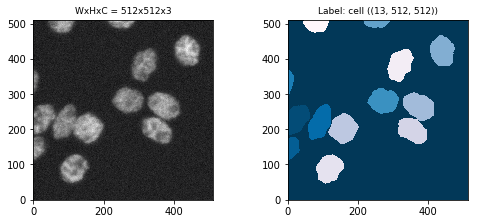

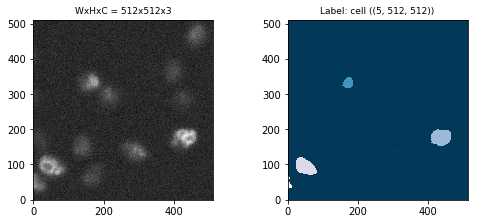

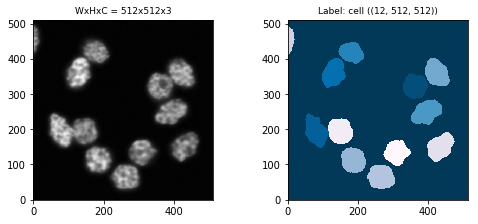

In [24]:
config['SOLVER']['IMS_PER_BATCH'] = 3
config['TEST']['IMS_PER_BATCH'] = 3

# Number of batch to load
n = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=7, limit=1, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])